In [1]:
!git clone https://github.com/herm23/Project-NNDL.git

Cloning into 'Project-NNDL'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 77 (delta 17), reused 72 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (77/77), 3.70 MiB | 36.40 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [2]:
%cd Project-NNDL/

/content/Project-NNDL


Link per il datset di CompCar (trovato su sito ufficiale): https://drive.google.com/drive/folders/18EunmjOJsbE5Lh9zA0cZ4wKV6Um46dkg


In [3]:
!pip install -U -q PyDrive

Import necessari

In [4]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

Scarico i dati direttamente dal drive pubblico

In [5]:
#Autenticazione
auth.authenticate_user()

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
# Estrazione dei dati dalla cartella
# ID della cartella pubblica
folder_id = '18EunmjOJsbE5Lh9zA0cZ4wKV6Um46dkg'

# Cartella locale per salvare i dati
save_path = '/content/Project-NNDL/compcar_dataset'
os.makedirs(save_path, exist_ok=True)

# Lista file nella cartella Drive
file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

# Scarica tutti i file
for file in file_list:
    print(f"Scaricando {file['title']}")
    file.GetContentFile(os.path.join(save_path, file['title']))



Scaricando sv_data.zip
Scaricando sv_data.z03
Scaricando sv_data.z02
Scaricando sv_data.z01
Scaricando data.zip
Scaricando data.z22
Scaricando data.z21
Scaricando data.z20
Scaricando data.z19
Scaricando data.z18
Scaricando data.z17
Scaricando data.z16
Scaricando data.z15
Scaricando data.z14
Scaricando data.z13
Scaricando data.z12
Scaricando data.z11
Scaricando data.z10
Scaricando data.z09
Scaricando data.z08
Scaricando data.z07
Scaricando data.z06
Scaricando data.z05
Scaricando data.z04
Scaricando data.z03
Scaricando data.z02
Scaricando data.z01
Scaricando README.txt


In [7]:
!apt-get install -y p7zip-full


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [8]:
%cd /content/Project-NNDL/compcar_dataset

/content/Project-NNDL/compcar_dataset


password per unzippare: d89551fd190e38

In [9]:
!7z x data.zip -o./compcar_dataset/unzipped


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 391417395 bytes (374 MiB)

Extracting archive: data.zip
  1% 4096 Open               90% 299008 Open                --
Path = data.zip
Type = zip
Physical Size = 391417395
Embedded Stub Size = 4
64-bit = +
Total Physical Size = 16539487795
Multivolume = +
Volume Index = 22
Volumes = 23

  0%    
Enter password (will not be echoed):
  0% 5 - data/image/1/1101/2011/07b90decb92ba6.jpg                                                    0% 144 - data/image/1/1112/2013/16179e5d599552.jpg                  

dataset

In [10]:
import os
from PIL import Image
from torch.utils.data import Dataset
import scipy.io as sio

class CompCarsSubsetDataset(Dataset):
    def __init__(self, image_root, mat_path, list_txt_path, transform=None, label_type='make'):
        self.image_root = image_root
        self.transform = transform
        label_type = label_type.lower()
        if label_type not in ['make', 'model']:
            raise ValueError("label_type deve essere 'make' o 'model'")
        self.label_type = label_type
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        # Carica i nomi da .mat
        mat = sio.loadmat(mat_path)

        if self.label_type == "make":
            names = [name[0] for name in mat['make_names'][:, 0]]
            id_to_name = {i+1: names[i] for i in range(len(names))}
        else:  # model
            names = [name[0] for name in mat['model_names'][:, 0] if len(name) > 0]
            id_to_name = {i+1: names[i] for i in range(len(names))}

        # Leggi immagini
        with open(list_txt_path, 'r') as f:
            img_names = f.read().splitlines()

        # 1. Trova le label effettivamente usate nel dataset
        used_label_names = set()
        temp_samples = []

        for img_name in img_names:
            img_path = os.path.join(image_root, img_name)
            parts = img_name.split('/')

            if self.label_type == 'make':
                make_id = int(parts[0])
                if make_id not in id_to_name:
                    continue
                label_name = id_to_name[make_id]
            else:
                if len(parts) < 2:
                    continue
                model_id = int(parts[1])
                if model_id not in id_to_name:
                    continue
                label_name = id_to_name[model_id]

            used_label_names.add(label_name)
            temp_samples.append((img_path, label_name))  # salva per dopo

        # 2. Costruisci mapping compatto: solo classi usate
        for idx, name in enumerate(sorted(used_label_names)):
            self.class_to_idx[name] = idx
            self.idx_to_class[idx] = name

        # 3. Finalizza i sample con le nuove etichette compatte
        for img_path, label_name in temp_samples:
            label = self.class_to_idx[label_name]
            self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
from torchvision.transforms import transforms, ToTensor
import torch

image_root = '/content/Project-NNDL/compcar_dataset/compcar_dataset/unzipped/data/image'
mat_path = '/content/Project-NNDL/compcar_dataset/compcar_dataset/unzipped/data/misc/make_model_name.mat'
list_txt_path_train = '/content/Project-NNDL/compcar_dataset/compcar_dataset/unzipped/data/train_test_split/classification/train.txt'
list_txt_path_test = '/content/Project-NNDL/compcar_dataset/compcar_dataset/unzipped/data/train_test_split/classification/test.txt'

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.95, 1.0)),  # più conservativo
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_dataset = CompCarsSubsetDataset(image_root, mat_path, list_txt_path_train, transform=train_transform, label_type='model')
train_dataset_val = CompCarsSubsetDataset(image_root, mat_path, list_txt_path_train, transform=transform, label_type='model')
#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataset = CompCarsSubsetDataset(image_root, mat_path, list_txt_path_test, transform=transform, label_type='model')
#test_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

In [13]:
from collections import Counter

# Assumendo che train_dataset sia istanza di CompCarsSubsetDataset
labels = [label for _, label in train_dataset]

# Conta quante volte appare ogni label
label_counts = Counter(labels)

# Numero totale di classi
num_classes = len(set(labels))

print(f"Numero totale classi: {num_classes}")
print("Distribuzione esempi per classe:")
for label_idx, count in label_counts.items():
    class_name = train_dataset.idx_to_class[label_idx]
    print(f"Classe {label_idx} ({class_name}): {count} esempi")


Numero totale classi: 368
Distribuzione esempi per classe:
Classe 9 (Audi A3 hatchback): 71 esempi
Classe 10 (Audi A4L): 84 esempi
Classe 12 (Audi A6L): 69 esempi
Classe 16 (Audi Q3): 33 esempi
Classe 17 (Audi Q5): 78 esempi
Classe 20 (Audi RS Q3): 28 esempi
Classe 11 (Audi A5 hatchback): 43 esempi
Classe 13 (Audi A7): 20 esempi
Classe 14 (Audi A8L): 47 esempi
Classe 15 (Audi A8L hybrid): 56 esempi
Classe 18 (Audi Q5 hybrid): 53 esempi
Classe 19 (Audi R8): 54 esempi
Classe 22 (Audi S5 convertible): 91 esempi
Classe 23 (Audi SQ5): 74 esempi
Classe 24 (Audi TTS coupe): 30 esempi
Classe 25 (Audi Urban): 28 esempi
Classe 21 (Audi S3 hatchback): 35 esempi
Classe 8 (Audi A3 convertible): 43 esempi
Classe 29 (BWM 1 Series couple): 143 esempi
Classe 30 (BWM 2 Series): 66 esempi
Classe 31 (BWM 3 Series GT): 118 esempi
Classe 32 (BWM 4 Series convertible): 30 esempi
Classe 33 (BWM 7 Series): 16 esempi
Classe 34 (BWM 7 Series hybrid): 21 esempi
Classe 36 (BWM X3): 16 esempi
Classe 37 (BWM X5): 24

In [13]:
from sklearn.model_selection import train_test_split

# Supponiamo tu abbia una lista di immagini e relativi label
all_indices = list(range(len(train_dataset)))
all_labels = [train_dataset[i][1] for i in all_indices]  # etichette di tutte le immagini

train_idx, val_idx = train_test_split(all_indices, test_size=0.2, stratify=all_labels, random_state=42)

# Ora crei Subset per train e validation
from torch.utils.data import Subset

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(train_dataset_val, val_idx)

In [15]:
print(len(train_dataset))
print(len(train_subset))  # ti stampa il numero di elementi nel subset
print(len(val_subset))
print(len(test_dataset))

14024
11219
2805
13086


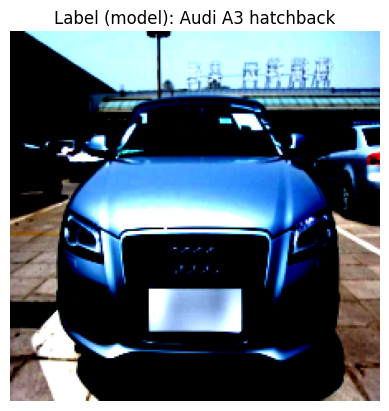

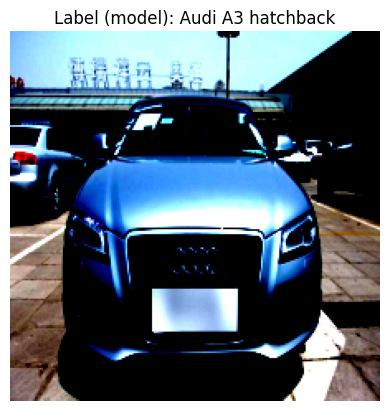

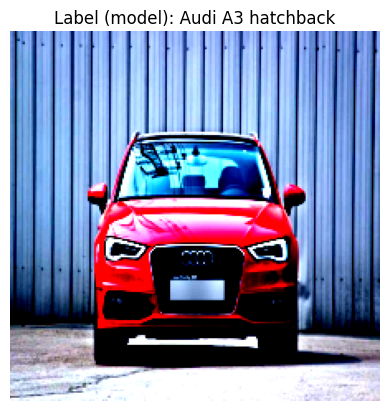

In [14]:
import matplotlib.pyplot as plt

img, label = train_dataset[0]
img1, label1 = test_dataset[0]
img2, label2 = train_dataset_val[0]

plt.imshow(img.permute(1, 2, 0).numpy())
plt.title(f"Label (model): {train_dataset.idx_to_class[label]}")
plt.axis('off')
plt.show()

plt.imshow(img2.permute(1, 2, 0).numpy())
plt.title(f"Label (model): {train_dataset_val.idx_to_class[label2]}")
plt.axis('off')
plt.show()

plt.imshow(img1.permute(1, 2, 0).numpy())
plt.title(f"Label (model): {test_dataset.idx_to_class[label1]}")
plt.axis('off')
plt.show()

# CNN

In [15]:
from torchvision.transforms import transforms, ToTensor
import torchvision
import torch
import os
import pandas as pd
import h5py
import random
import numpy as np

NUM_WORKERS = os.cpu_count()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

# path
img = '/content/Project-NNDL/compcar_dataset/compcar_dataset/unzipped/data/image'
maker_path = '/content/Project-NNDL/compcar_dataset/compcar_dataset/unzipped/data/misc/make_model_name.mat'

Device: cuda:0
Number of workers: 12


Rete formata da encoder=ResNet34 e trasformhead=2 linear layers

In [16]:
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU, MaxPool2d, AdaptiveAvgPool2d, Linear, Dropout
from torchvision.models import resnet34

class Classifier_Model(Module):

    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
                          nn.Linear(feature_dim, 256),
                          nn.BatchNorm1d(256),
                          nn.ReLU(),
                          nn.Dropout(0.5),
                          nn.Linear(256, num_classes)
                      )


    def forward(self, x):
        return self.classifier(x)

class SimCLR(Module):
    def __init__(self):
        super().__init__()
        resnet = resnet34(pretrained=True)
        modules = list(resnet.children())[:-1]  # rimuove FC
        self.convnet = nn.Sequential(*modules)
        self.classifier = Classifier_Model(512, 368)

    def forward(self, x):
        x = self.convnet(x).reshape(x.size(0), -1)
        return self.classifier(x)

train

In [17]:
import torch.nn.functional as F
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha  # float semplice, non tensor
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')  # loss per ogni esempio
        pt = torch.exp(-ce_loss)  # probabilità della classe corretta

        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [18]:
import torch
import torch.nn as nn
import numpy as np

def train(model, device, train_loader, optimizer, lr_scheduler, epoch, maxit=float('inf')):
    train_losses = []
    accs = []
    criterion = FocalLoss(alpha=1.0, gamma=2.0)

    model.train()
    model.to(device)
    for i, batch in enumerate(train_loader):
        feats, labels = batch
        feats = feats.to(device)
        labels = labels.to(device)

        # Forward pass
        preds = model(feats)

        # Compute the cross entropy loss
        loss = criterion(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        train_losses.append(loss.item())
        accs.append(acc.item())

        # Backpropagate the loss and perform the optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Train Epoch: {epoch}, Iteration: {i}/{len(train_loader)},  \tLoss: {loss.item():.6f}, \tAcc: {acc.item():.6f}")

        if i >= maxit:
            return np.mean(train_losses), np.mean(accs)
            break

    lr_scheduler.step()
    return np.mean(train_losses), np.mean(accs)

@torch.no_grad()
def validate(model, device, val_loader):
    val_losses = []
    accs = []
    criterion = FocalLoss(alpha=1.0, gamma=2.0)

    model.eval()
    model.to(device)
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            feats, labels = batch
            feats = feats.to(device)
            labels = labels.to(device)

            preds = model(feats)
            loss = criterion(preds, labels)
            acc = (preds.argmax(dim=-1) == labels).float().mean()

            val_losses.append(loss.item())
            accs.append(acc.item())

            print(f"Validation Iteration: {i}/{len(val_loader)}, \tLoss: {loss.item():.6f}, \tAcc: {acc.item():.6f}")

    return np.mean(val_losses), np.mean(accs)


In [22]:
num_classes = print(len(train_dataset.class_to_idx))
labels = [label for _, label in train_dataset]
print("Min label:", min(labels))
print("Max label:", max(labels))
print("Num classi:", len(set(labels)))

368
Min label: 0
Max label: 367
Num classi: 368


In [19]:
from torch.utils import data
from torch.utils.data import DataLoader
import torch.optim as optim
import os
from google.colab import drive
drive.mount('/content/drive')

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define training hyperparameters
weight_decay=1e-4
batch_size = 128
max_epochs=500
lr=1e-3

epochs = 100
maxit = float('inf')

train_dataloader = data.DataLoader(train_subset, batch_size=batch_size, shuffle=True,
                                drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
val_dataloader = data.DataLoader(val_subset, batch_size=batch_size, shuffle=False,
                                drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

# Define the simple classifier model
model = SimCLR()
model.to(device)

# Define Optimizer and Learning rate Scheduler
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = max_epochs, eta_min=lr/50)

# Training Loop
train_losses = []
val_losses = []
train_accs = []
val_accs = []
patience = 3
counter = 0
best_val_loss = float('inf')

checkpoint_dir = "/content/drive/MyDrive/NNDL/progetto/classifierNN"

for epoch in range(epochs):
    train_loss, train_acc = train(model, device, train_dataloader,
                                  optimizer, lr_scheduler, epoch, maxit=maxit)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}")

    # Validazione
    val_loss, val_acc = validate(model, device, val_dataloader)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}: Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # reset counter

        # Salva modello
        checkpoint = {
          'epoch': epoch + 1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'lr_scheduler_state_dict': lr_scheduler.state_dict(),
        }
        torch.save(checkpoint, os.path.join(checkpoint_dir, f'model_CNN_model.pth'))
        print(f"Saved model checkpoint at epoch {epoch+1}")

    else:
        counter += 1
        print(f"No improvement in val_loss for {counter} epochs.")

        if counter >= patience:
            print("Early stopping triggered.")
            break

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 224MB/s]


Train Epoch: 0, Iteration: 0/88,  	Loss: 6.060119, 	Acc: 0.007812
Train Epoch: 0, Iteration: 1/88,  	Loss: 6.052703, 	Acc: 0.000000
Train Epoch: 0, Iteration: 2/88,  	Loss: 5.997364, 	Acc: 0.007812
Train Epoch: 0, Iteration: 3/88,  	Loss: 5.951324, 	Acc: 0.000000
Train Epoch: 0, Iteration: 4/88,  	Loss: 6.060180, 	Acc: 0.000000
Train Epoch: 0, Iteration: 5/88,  	Loss: 6.013795, 	Acc: 0.000000
Train Epoch: 0, Iteration: 6/88,  	Loss: 5.825602, 	Acc: 0.007812
Train Epoch: 0, Iteration: 7/88,  	Loss: 5.990850, 	Acc: 0.007812
Train Epoch: 0, Iteration: 8/88,  	Loss: 5.896613, 	Acc: 0.015625
Train Epoch: 0, Iteration: 9/88,  	Loss: 5.993945, 	Acc: 0.000000
Train Epoch: 0, Iteration: 10/88,  	Loss: 5.894823, 	Acc: 0.023438
Train Epoch: 0, Iteration: 11/88,  	Loss: 5.924921, 	Acc: 0.000000
Train Epoch: 0, Iteration: 12/88,  	Loss: 5.852038, 	Acc: 0.007812
Train Epoch: 0, Iteration: 13/88,  	Loss: 5.960644, 	Acc: 0.015625
Train Epoch: 0, Iteration: 14/88,  	Loss: 5.848684, 	Acc: 0.000000
Train

Results

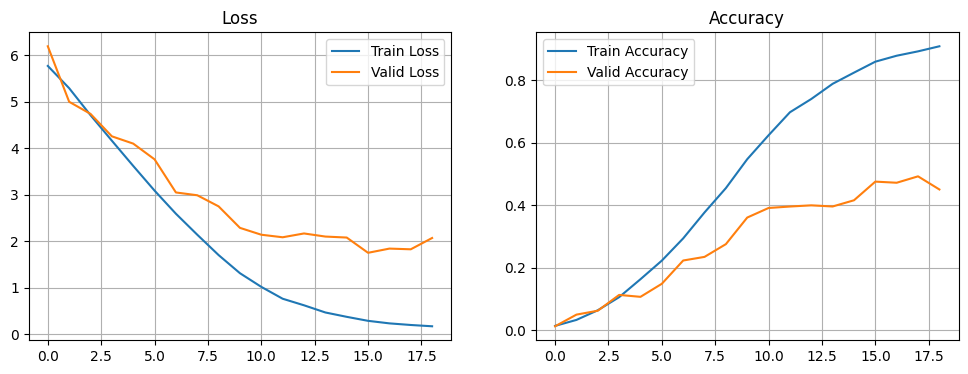

In [20]:
import matplotlib.pyplot as plt
# Let's plot the training and validation losses and Accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(train_losses, label='Train Loss')
ax[0].plot(val_losses, label='Valid Loss')

ax[1].plot(train_accs, label='Train Accuracy')
ax[1].plot(val_accs, label='Valid Accuracy')

ax[0].set_title('Loss')
ax[1].set_title('Accuracy')

for i in range(2):
    ax[i].legend()
    ax[i].grid()

plt.show()

test

In [21]:
import torch
import torch.nn as nn
import numpy as np

def test(model, device, test_loader):
    model.eval()  # modalità evaluation
    criterion = FocalLoss(alpha=1.0, gamma=2.0)
    test_losses = []
    accs = []

    with torch.no_grad():  # niente gradiente
        for batch in test_loader:
            feats, labels = batch
            feats = feats.to(device)
            labels = labels.to(device)

            preds = model(feats)
            loss = criterion(preds, labels)
            acc = (preds.argmax(dim=-1) == labels).float().mean()

            test_losses.append(loss.item())
            accs.append(acc.item())

    avg_loss = np.mean(test_losses)
    avg_acc = np.mean(accs)

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_acc:.4f}")

    return avg_loss, avg_acc


In [22]:
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                 drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

# Define the simple classifier model
model = SimCLR()
model.to(device)

# Carica checkpoint del modello allenato
checkpoint_path = "/content/drive/MyDrive/NNDL/progetto/classifierNN/model_CNN_model.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc = test(model, device, test_dataloader)


Test Loss: 1.6973, Test Accuracy: 0.4900
